In [41]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines
import json

In [49]:
model_type = 'robust'
norm = np.inf
max_iterations = 500

In [50]:
file_path = f'../data/paper_data/adv_dist_vs_clever_{model_type}_500.json'

# load the data
with open(file_path, 'r') as f:
    results_dict = json.load(f)

In [51]:
image_ids = np.arange(len(results_dict[f'{norm}']['adversarial_distance_pgd']))
clever_values = results_dict[f'{norm}']['clever_score']
pgd_values = results_dict[f'{norm}']['adversarial_distance_pgd']
cw_values = results_dict[f'{norm}']['adversarial_distance_second_attack']

In [52]:
min_attack_value = []
for i in range(len(image_ids)):
    if pgd_values[i] is not None and cw_values[i] is not None:
        if pgd_values[i] == 0.0 and cw_values[i] == 0.0:
            pgd_values[i] = None
            cw_values[i] = None
            clever_values[i] = None
            min_attack_value.append(None)
        else:
            min_attack_value.append(min(pgd_values[i], cw_values[i]))
    elif pgd_values[i] is not None:
        min_attack_value.append(pgd_values[i])
    elif cw_values[i] is not None:
        min_attack_value.append(cw_values[i])
    else:
        min_attack_value.append(None)

In [53]:
sorted_indices = np.argsort([v if v is not None else float('inf') for v in min_attack_value])
pgd_values = [pgd_values[i] for i in sorted_indices]
cw_values = [cw_values[i] for i in sorted_indices]
clever_values = [clever_values[i] for i in sorted_indices]
min_values = [min_attack_value[i] for i in sorted_indices]
image_ids = np.arange(len(sorted_indices))

In [54]:
# Calculate the error proportion
total_points = 0
red_points = 0

for i in range(len(image_ids)):
    if min_values[i] is not None:
        total_points += 1
        if clever_values[i] > min_values[i]:
            red_points += 1

error_proportion = (red_points / total_points) * 100 if total_points > 0 else 0

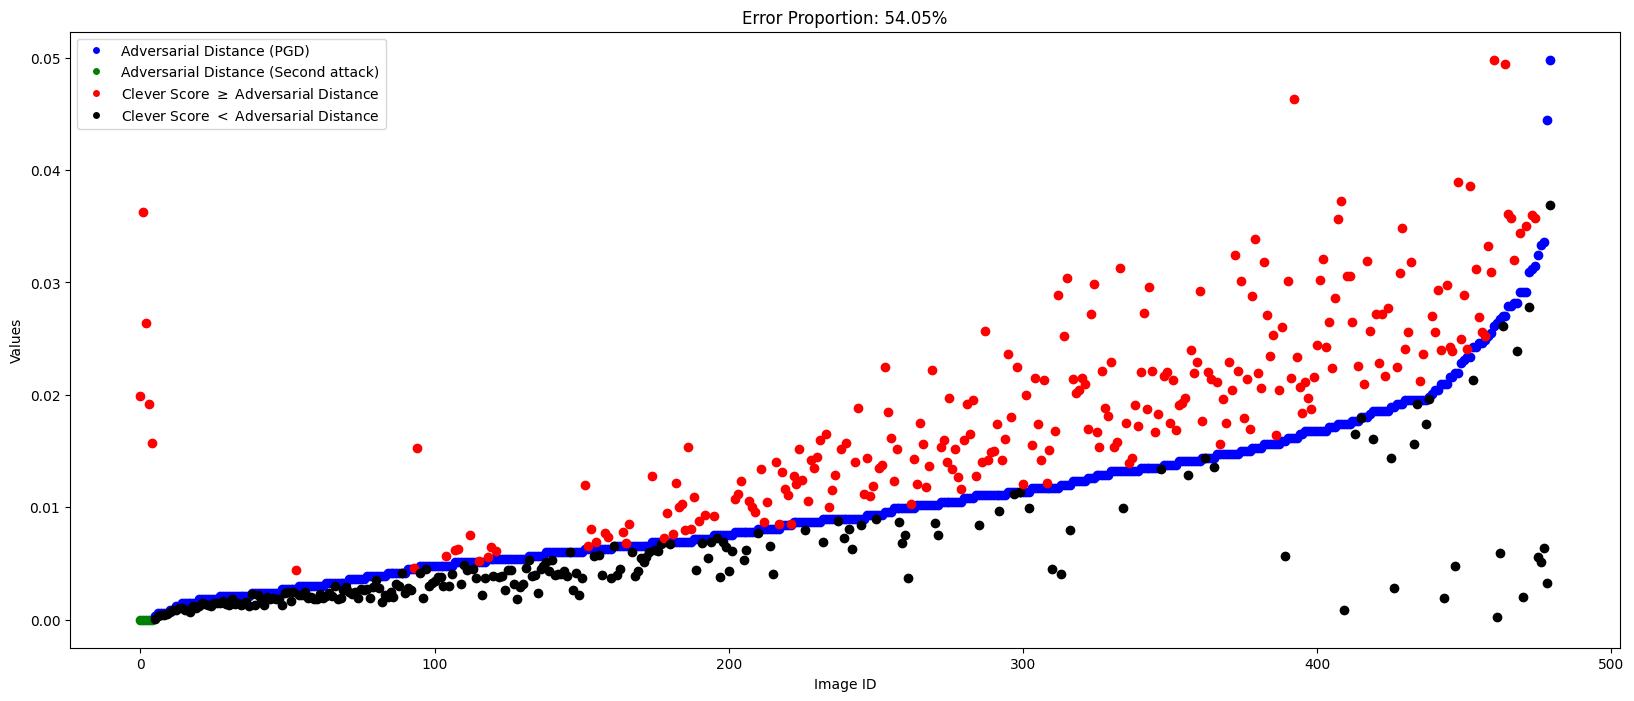

In [55]:
# Plotting
plt.figure(figsize=(20, 8))

# Plotting pgd and cw with respective conditions
for i in range(len(image_ids)):
    if pgd_values[i] is not None and cw_values[i] is None:
        plt.scatter(image_ids[i], pgd_values[i], color='blue', label='pgd' if i == 0 else "")
    elif cw_values[i] is not None and pgd_values[i] is None:
        plt.scatter(image_ids[i], cw_values[i], color='green', label='cw' if i == 0 else "")
    elif pgd_values[i] is not None and cw_values[i] is not None:
        min_value = min(pgd_values[i], cw_values[i])
        color = 'blue' if min_value == pgd_values[i] else 'green'
        plt.scatter(image_ids[i], min_value, color=color)

# Plotting clever with respective conditions
colors = []
for i in range(len(image_ids)):
    if clever_values[i] is not None and min_values[i] is not None:
        color = 'red' if clever_values[i] > min_values[i] else 'black'
        plt.scatter(image_ids[i], clever_values[i], color=color, label='clever' if i == 0 else "")
        colors.append(color)

# Adding labels and title with error proportion
plt.xlabel('Image ID')
plt.ylabel('Values')
plt.title(f'Error Proportion: {error_proportion:.2f}%')
plt.xticks(np.arange(0, len(sorted_indices), 100))

# Avoid label duplication in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

legend_elements = [
    mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', label='Adversarial Distance (PGD)'),
    mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', label='Adversarial Distance (Second attack)'),
    mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='Clever Score $\geq$ Adversarial Distance'),
    mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', label='Clever Score $<$ Adversarial Distance')
]
plt.legend(handles=legend_elements, fontsize=10)
plt.show()